In [2]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder  
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from scipy.stats import skew
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
USELESS_DATA_BOUNDARY= 0.3
FEATURE_FILTER_BOUNDARY = 0.03

In [49]:
class DataSet(object):
    def __init__(self, csv_path):
        self.data = pd.read_csv(csv_path)
        self.processed_data = self.data

        #self.raw_predictor = self.data.iloc[:,:-1].values
        #self.raw_response = self.data.iloc[:,-1].values

        self.useless_value_process()
        self.missing_value_process()
        self.tag_transfer()
        self.imputer_process()
        self.normalize()
        self.feature_filter()

    def useless_value_process(self):
        col_del = ['examide', 'citoglipton', 'glimepiride-pioglitazone','encounter_id','patient_nbr']
        self.processed_data.drop(col_del, axis=1, inplace = True)
    
    def missing_value_process(self):
        row_num = len(self.processed_data)
        col_num = len(self.processed_data.columns)
        cols_to_drop = []
        # Check all the features
        for col in range(col_num):
            # qm is short for Question Mark, which indicates a missing value
            qm_num = 0
            for row in range(row_num):
                # Check if the value is missing
                if str(self.processed_data.iat[row,col]) == "?":
                    qm_num += 1

            # Print(qm_num/row_num), the percentage of missing values
            if qm_num/row_num >= USELESS_DATA_BOUNDARY:
                # Print("true") if the percentage is greater than the set boundary, and add the column to columns to drop
                cols_to_drop.append(self.processed_data.columns[col])
        # Drop column
        self.processed_data.drop(columns=cols_to_drop, axis=1, inplace = True)

    def imputer_process(self):
        # Replace the question marks with the most frequently appeared value for each feature
        imp = SimpleImputer(missing_values= -1, strategy='most_frequent')
        imp.fit(self.processed_data)

    def tag_transfer(self): 

        le = LabelEncoder()
        #self.processed_data.replace('?', -1, inplace=True)
        value_to_keep = "?"

        # 遍历DataFrame的每一列
        for column in self.processed_data.columns:
            # 如果列的数据类型是对象（通常意味着它是分类类型）
            if self.processed_data[column].dtype == 'object':
                # 对列应用 LabelEncoder
                values_to_encode = self.processed_data[column] != value_to_keep
                #original_column = self.processed_data[column].copy()
                # 对非特定值应用 LabelEncode
                self.processed_data[column] = le.fit_transform(self.processed_data[column])
                self.processed_data[column].fillna(self.processed_data[column], inplace=True)

    def get_integer_mapping(self, le):
    
        res = {}
    
        for cl in le.classes_:
    
            res.update({cl:le.transform([cl])[0]})
    
        return res

    def normalize(self):
        # Normalize data using StandardScaler
        scaler = StandardScaler()

        # Assuming self.processed_data is a DataFrame
        # 提取列标题
        column_names = self.processed_data.columns

        # Fit and transform the data
        self.processed_data = scaler.fit_transform(self.processed_data)

        # Convert the normalized data back to a DataFrame
        # 并保留原始的列标题
        self.processed_data = pd.DataFrame(self.processed_data, columns=column_names)

        # Print normalized data
        print(self.processed_data)

    def feature_filter(self):
        importances = self.processed_data.drop('readmitted', axis=1).apply(lambda x: x.corr(self.processed_data.readmitted))

        # 只保留相关性高于阈值的特征
        importances = importances[importances.abs() > FEATURE_FILTER_BOUNDARY]

        # 获取排序后的索引
        indices = np.argsort(importances)

        plt.title('Readmitted')
        plt.barh(range(len(indices)), importances[indices], color='g', align='center')
        plt.yticks(range(len(indices)), [importances.index[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()
    

           race    gender       age  admission_type_id  \
0      0.437862 -0.923795 -3.830404           2.724943   
1     -1.703474 -0.923795 -1.318393          -0.713417   
2     -2.774141 -0.923795 -0.690390          -0.025745   
3     -1.703474 -0.923795 -0.062387          -0.713417   
4      0.437862 -0.923795  0.565616          -0.713417   
...         ...       ...       ...                ...   
10172  0.437862  1.082492 -0.690390          -0.025745   
10173 -1.703474 -0.923795  0.565616          -0.713417   
10174  0.437862  1.082492 -1.318393           0.661927   
10175  0.437862 -0.923795  1.193619           0.661927   
10176 -1.703474 -0.923795 -0.062387          -0.713417   

       discharge_disposition_id  admission_source_id  time_in_hospital  \
0                      4.064813            -1.156490         -1.148831   
1                     -0.513085             0.316674          1.554364   
2                     -0.513085            -0.419908         -0.810932   
3      

/Users/yorux/anaconda3/envs/jupyter/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/yorux/anaconda3/envs/jupyter/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/var/folders/f7/9y25vsd52n13lfvkbwc3yvch0000gn/T/ipykernel_26297/221567219.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.barh(range(len(indices)), importances[indices], color='g', align='center')


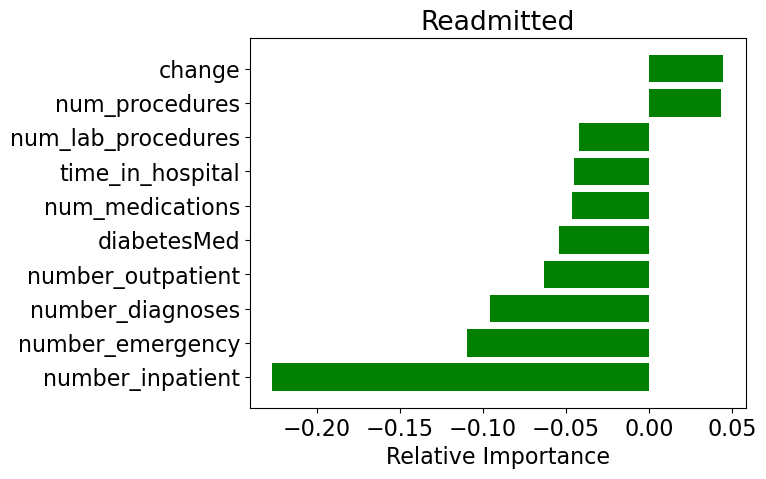

In [50]:
#train_data = DataSet('diabetic_data.csv')
#train_data = DataSet('diabetic_data_training.csv')
test_data = DataSet('diabetic_data_test.csv')

#train_data.data

#test_data.processed_data
#train_data.processed_data.to_csv("test.csv",index=False)

In [13]:
# export the normalized data as an Excel file
df = pd.read_csv('test_csv.csv')
df.to_excel('normalized_new_dataset.xlsx', index = False, header=True)

In [14]:
train_data = pd.read_csv('diabetic_data.csv')
test_data = pd.read_csv('diabetic_data_test.csv')

predictor = train_data.iloc[:,:-1].values
response = train_data.iloc[:,-1].values

predictor,response 

(array([[2278392, 8222157, 'Caucasian', ..., 'No', 'No', 'No'],
        [149190, 55629189, 'Caucasian', ..., 'No', 'Ch', 'Yes'],
        [64410, 86047875, 'AfricanAmerican', ..., 'No', 'No', 'Yes'],
        ...,
        [443854148, 41088789, 'Caucasian', ..., 'No', 'Ch', 'Yes'],
        [443857166, 31693671, 'Caucasian', ..., 'No', 'Ch', 'Yes'],
        [443867222, 175429310, 'Caucasian', ..., 'No', 'No', 'No']],
       dtype=object),
 array(['NO', '>30', 'NO', ..., 'NO', 'NO', 'NO'], dtype=object))

/var/folders/f7/9y25vsd52n13lfvkbwc3yvch0000gn/T/ipykernel_26297/1092844671.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.abs(importances[i]) <= FEATURE_FILTER_BOUNDARY:
/var/folders/f7/9y25vsd52n13lfvkbwc3yvch0000gn/T/ipykernel_26297/1092844671.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.barh(range(len(indices)), importances[indices], color='g', align='center')


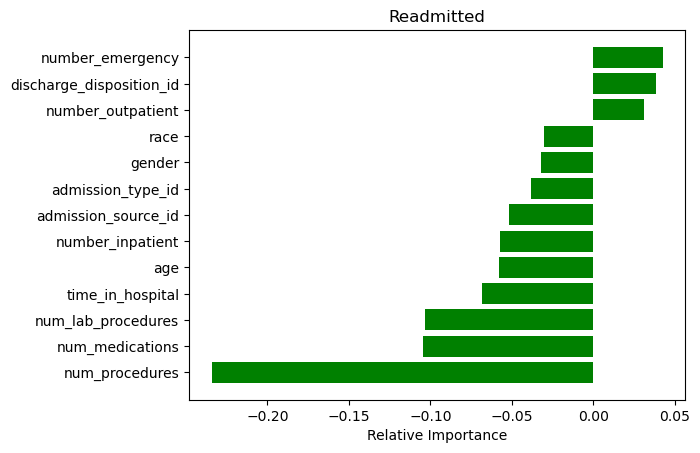

In [15]:
# Relative importance
processed_data = pd.read_csv('test.csv')
importances = processed_data.drop('readmitted', axis=1).apply(lambda x: x.corr(processed_data.readmitted))

names=[]
for col in processed_data.columns:
    names.append(col)
names.remove("readmitted")

indexes_to_drop = []
for i in range(0, len(importances)):
    if np.abs(importances[i]) <= FEATURE_FILTER_BOUNDARY:
        indexes_to_drop.append(i)
importances = importances.drop(importances.index[indexes_to_drop])

indices = np.argsort(importances)

plt.title('Readmitted')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [3]:
# Data Exploration part

# Read CSV file
data = pd.read_csv('diabetic_data.csv')

# Assuming 'data' is the dataset 
df = pd.DataFrame(data)

In [ ]:
# Plot the pie chart for Race Distribution

# Calculate the counts for different races
Caucasian_count = len(data[data['race'] == 'Caucasian'])
Asian_count = len(data[data['race'] == 'Asian'])
African_count = len(data[data['race'] == 'African'])
American_count = len(data[data['race'] == 'American'])
Hispanic_count = len(data[data['race'] == 'Hispanic'])
other_count = len(data[data['race'] == 'Other'])
total_count = len(data)

# Calculate percentages
p1 = (Caucasian_count / total_count) * 100
p2 = (Asian_count / total_count) * 100
p3 = (African_count / total_count) * 100
p6 = (American_count / total_count) * 100
p5 = (Hispanic_count / total_count) * 100
p4 = (other_count / total_count) * 100

print(f"Percentage Caucasian: {p1}%")
print(f"Percentage Asian: {p2}%")
print(f"Percentage African: {p3}%")
print(f"Percentage American: {p6}%")
print(f"Percentage Hispanic: {p5}%")
print(f"Percentage Other: {p4}%")

labels = ['Caucasian', 'Asian', 'African', 'other', 'Hispanic', 'America']
sizes = [p1, p2, p3, p4, p5, p6]  # Portions for the pie chart

# Set the colors
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'orange', 'pink']

# Plot the figure
plt.figure(figsize=(20, 20))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

# Set the title
plt.title('Race distribution')

# Show the plot
plt.axis('equal')  # Ensure it's a circle and not an ellipse
plt.legend() 
plt.show()

In [ ]:
# Plot the pie chart for A1Cresult Value

# Calculate the counts for different A1Cresult categories
normal_count = len(data[data['A1Cresult'] == 'Normal'])
gt_8_count = len(data[data['A1Cresult'] == '>8'])
gt_7_count = len(data[data['A1Cresult'] == '>7'])
none_count = len(data[data['A1Cresult'] == 'None'])
total_count = len(data)

# Calculate percentages
p1 = (normal_count / total_count) * 100
p2 = (gt_8_count / total_count) * 100
p3 = (gt_7_count / total_count) * 100
p4 = (none_count / total_count) * 100

print(f"Percentage Normal: {p1:.2f}%")
print(f"Percentage >8: {p2:.2f}%")
print(f"Percentage >7: {p3:.2f}%")
print(f"Percentage None: {p4:.2f}%")

labels = ['Normal', '>8','None', '>7']
sizes = [p1, p2, p4, p3]  # Portions for the pie chart

# Set the colors
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']

# Plot the figure
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

# Set the title
plt.title('A1Cresult Value')

# Show the plot
plt.axis('equal')  # Ensure it's a circle and not an ellipse
plt.legend(loc='upper right') 
plt.show()


In [ ]:
# PLot the Stacked Column Chart for Medicine use condition


# Define all the medicines
medicines = ['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','examide','citoglipton','insulin','glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone']  # 添加其他药物的名称

# create a vaccume list to fill the percentage
percentages = []

# write a loop to deal all of the medicines
for med in medicines:
    # write the percentage for each medicines
    values_count = data[med].value_counts(normalize=True) * 100
    
    # for none value use o to replace
    for value in ['No', 'Steady', 'Up', 'Down']:
        if value not in values_count:
            values_count[value] = 0
    
    # put the percentage into the value list
    percentages.append([values_count['No'], values_count['Steady'], values_count['Up'], values_count['Down']])

# define medicine name
medication_labels = [med.capitalize() for med in medicines]  # Using the first character

# define the colour 
colors = ["steelblue","dodgerblue", "lightskyblue", "blue"]

# create figure
fig, ax = plt.subplots(figsize=(12, 8))
fig.patch.set_facecolor('white') 

bottom = np.zeros(len(medicines))  # initialise the bottom height

for j in range(len(percentages[0])):
    values = [percentages[i][j] for i in range(len(medicines))]
    ax.bar(medicines, values, color=colors[j], bottom=bottom, label=["No", "Steady", "Up", "Down"][j])
    bottom += np.array(values)  # update the height

# set the title 
ax.set_title("Relationship between readmission and medicines", fontsize=15)
ax.set_xlabel("Name of medicines")
ax.set_ylabel("Percentage")
ax.legend()  

plt.xticks(medicines, medication_labels)  # x axis is the medicine name
plt.xticks(rotation=45)  # rotate name avoid overlap
ax.set_ylim(0, 105) 
plt.tight_layout()  
plt.show()

In [ ]:
# PLot the histogram and find the skewness of the Age groups.

# Create a numeric mapping for age categories for all patients
age_mapping = {age: idx for idx, age in enumerate(sorted(data['age'].unique()))}
data['age_numeric'] = data['age'].map(age_mapping)

# Calculate skewness for the age category
age_skewness = skew(data['age_numeric'])

# Plot the histogram with KDE and display the skewness on the plot
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=data, x='age_numeric', bins=len(age_mapping), kde=True, kde_kws={"bw_adjust": 3.5})
plt.title("Age Distribution with KDE for All Patients")
plt.xlabel("Age Category")
plt.ylabel("Density")
plt.xticks(ticks=range(len(age_mapping)), labels=sorted(data['age'].unique()), rotation=45)
plt.grid(True)

# Create a second y-axis to show the count
ax2 = ax.twinx()
sns.histplot(data=data, x='age_numeric', bins=len(age_mapping), ax=ax2, alpha=0.5)
ax2.set_ylabel('Count')

# Annotate skewness on the plot
ax.text(x=0.95, y=0.95, s=f"Skewness: {age_skewness:.2f}", horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)

In [17]:
# PLot the histogram and find the skewness of time in hospital.

# Calculate skewness for the time in hospital
time_in_hospital_skewness = skew(df['time_in_hospital'])

# Plot the histogram with KDE and display the skewness on the plot
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=df, x='time_in_hospital', bins=max(df['time_in_hospital']), kde=True, kde_kws={"bw_adjust": 3.5})
plt.title("Time in Hospital Distribution with KDE")
plt.xlabel("Time in Hospital (days)")
plt.ylabel("Density")
plt.xticks(ticks=range(1, max(df['time_in_hospital']) + 1))
plt.grid(True)

# Create a second y-axis to show the count
ax2 = ax.twinx()
sns.histplot(data=df, x='time_in_hospital', bins=max(df['time_in_hospital']), ax=ax2, alpha=0.5)
ax2.set_ylabel('Count')

# Annotate skewness on the plot
ax.text(x=0.95, y=0.95, s=f"Skewness: {time_in_hospital_skewness:.2f}", horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'normalized_new_dataset.csv'

In [ ]:
# Data Transformation Part

# Plot the Heatmap of the data

# Load CSV data into a Pandas DataFrame
data_1 = pd.read_csv('normalized_new_dataset.csv')

# Find the covariance matrix of the dataset
cov_matrix = np.cov(data_1, rowvar=False)

# Print the covariance matrix
print("Covariance Matrix:")
print(cov_matrix)

# Create a DataFrame from the covariance matrix
cov_df = pd.DataFrame(cov_matrix, columns=data.columns, index=data_1.columns)

# Create a heatmap using seaborn
plt.figure(figsize=(60, 60))
sns.heatmap(cov_df, annot=True, cmap='Greens', fmt='.2f', linewidths=.5)
plt.title('Covariance Matrix Heatmap')
plt.show()

# Select the relevant features and the target variable
selected_features = [
    'number_inpatient', 'number_emergency', 'number_diagnoses',
    'number_outpatient', 'time_in_hospital', 'diabetesMed',
    'num_medications', 'change', 'num_procedures', 'num_lab_procedures', 'readmitted'
]

# Create a subset of the data with the selected features
subset_data = data_1[selected_features]

# Compute the covariance matrix
cov_matrix = subset_data.cov()

# Plot the covariance matrix heatmap using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(cov_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Covariance Matrix Heatmap of The Most Important Features')
plt.show()

In [ ]:
# Plot the # PLot the Stacked Column Chart for The change in medications

# Set the limitations to find the desirable line
d1 = len(df[(df['change'] == 'No') & (df['readmitted'] == 'NO')])
d2 = len(df[(df['change'] == 'No') & (df['readmitted'] == '<30')])
d3 = len(df[(df['change'] == 'No') & (df['readmitted'] == '>30')])
d4 = len(df[(df['change'] == 'Ch') & (df['readmitted'] == 'NO')])
d5 = len(df[(df['change'] == 'Ch') & (df['readmitted'] == '<30')])
d6 = len(df[(df['change'] == 'Ch') & (df['readmitted'] == '>30')])

# Define the total line
total_line = len(df)

# Calculate the percentage of the desirable line over the total line
p1 = (d1 / total_line) * 100
p2 = (d2 / total_line) * 100
p3 = (d3 / total_line) * 100
p4 = (d4 / total_line) * 100
p5 = (d5 / total_line) * 100
p6 = (d6 / total_line) * 100

# Print the actual percentage
print(total_line)
print(f"change 'No' and readmitted 'NO': {p1}%")
print(f"change 'No' and readmitted '<30': {p2}%")
print(f"change 'No' and readmitted '>30': {p3}%")
print(f"change 'Ch' and readmitted 'NO': {p4}%")
print(f"change 'Ch' and readmitted '<30': {p5}%")
print(f"change 'Ch' and readmitted '>30': {p6}%")

#define the two bars
readmission = ["change", "NO change"]
NO = [p1, p4]  # You might want to replace p1, p4 with actual numerical values
less_than_30_days = [p2, p5]  # Fix variable names with underscores
more_than_30_days = [p3, p6]  # Fix variable names with underscores

#define the size of the bar
fig, ax = plt.subplots(figsize=(10, 7))
#define the backfround colour
fig.patch.set_facecolor('white') 
#ax.grid(color='white') 

# Plotting the bars with different colours
ax.bar(readmission, NO, color="darkolivegreen", label="NO")
ax.bar(readmission, less_than_30_days, color="darkgreen", bottom=NO, label="Less than 30 days")
ax.bar(readmission, more_than_30_days, color="darkseagreen", bottom=np.array(less_than_30_days) + np.array(NO), label="More than 30 days")

# Set plot labels and title
ax.set_title("Relationship between readission and Change in diabetic medications", fontsize=15)
ax.set_xlabel("Change condition")
ax.set_ylabel("Percentage")
ax.legend()  # If 'A' is supposed to be the legend label, use ax.legend(["A"])

plt.show()  # Display the plot

In [ ]:
# PLot the Stacked Column Chart for diabetesMed

# Set the limitations to find the desirable line
d1 = len(df[(df['diabetesMed'] == 'No') & (df['readmitted'] == 'NO')])
d2 = len(df[(df['diabetesMed'] == 'No') & (df['readmitted'] == '<30')])
d3 = len(df[(df['diabetesMed'] == 'No') & (df['readmitted'] == '>30')])
d4 = len(df[(df['diabetesMed'] == 'Yes') & (df['readmitted'] == 'NO')])
d5 = len(df[(df['diabetesMed'] == 'Yes') & (df['readmitted'] == '<30')])
d6 = len(df[(df['diabetesMed'] == 'Yes') & (df['readmitted'] == '>30')])

# Define the total line
total_line = len(df)

# Calculate the percentage of the desirable line over the total line
p1 = (d1 / total_line) * 100
p2 = (d2 / total_line) * 100
p3 = (d3 / total_line) * 100
p4 = (d4 / total_line) * 100
p5 = (d5 / total_line) * 100
p6 = (d6 / total_line) * 100

# Print the actual percentage
print(total_line)
print(f"diabetesMed 'No' and readmitted 'NO': {p1}%")
print(f"diabetesMed 'No' and readmitted '<30': {p2}%")
print(f"diabetesMed 'No' and readmitted '>30': {p3}%")
print(f"diabetesMed 'Yes' and readmitted 'NO': {p4}%")
print(f"diabetesMed 'Yes' and readmitted '<30': {p5}%")
print(f"diabetesMed 'Yes' and readmitted '>30': {p6}%")

# import the figure plotting code
import matplotlib.pyplot as plt
import numpy as np

#define the two bars
readmission = ["Yes", "NO"]
NO = [p4, p1]  # You might want to replace p1, p4 with actual numerical values
less_than_30_days = [p5, p2]  # Fix variable names with underscores
more_than_30_days = [p6, p3]  # Fix variable names with underscores

#define the size of the bar
fig, ax = plt.subplots(figsize=(10, 7))
#define the backfround colour
fig.patch.set_facecolor('white') 
#ax.grid(color='white') 

# Plotting the bars with different colours
ax.bar(readmission, NO, color="darkolivegreen", label="NO")
ax.bar(readmission, less_than_30_days, color="darkgreen", bottom=NO, label="Less than 30 days")
ax.bar(readmission, more_than_30_days, color="darkseagreen", bottom=np.array(less_than_30_days) + np.array(NO), label="More than 30 days")

# Set plot labels and title
ax.set_title("Relationship between readmission and diabetesMed", fontsize=15)
ax.set_xlabel("DiabetesMed prescribed")
ax.set_ylabel("Percentage")
ax.legend()  # If 'A' is supposed to be the legend label, use ax.legend(["A"])

plt.show()  # Display the plot

In [ ]:
# Plot the distribution for Time in Hospital

# Check the unique values in the 'readmitted' column to understand what categories we have
readmitted_categories = df['readmitted'].unique()

# Set up the matplotlib figure
plt.figure(figsize=(12, 6))


# Loop through each race and plot the distribution of 'time_in_hospital'
for readmitted in readmitted_categories:
    # Exclude rows where readitted is not specified ('?')
    if readmitted != '?':
        subset = df[df['readmitted'] == readmitted]['time_in_hospital']
        sns.kdeplot(subset, fill=True, label=readmitted, bw_adjust=2)

# Add plot title and labels
plt.title('Distribution of Hospital Stay Duration by readmitted status')
plt.xlabel('Time in Hospital (Days)')
plt.ylabel('Density')

# Display the legend
plt.legend(title='Readmitted status')

# Show the plot
plt.show()

In [ ]:
# Plot the distribution for Number of medications


readmitted_categories = df['readmitted'].unique()

# Set up the matplotlib figure
plt.figure(figsize=(12, 6))


# Loop through each race and plot the distribution of 'time_in_hospital'
for readmitted in readmitted_categories:
    # Exclude rows where readitted is not specified ('?')
    if readmitted != '?':
        subset = df[df['readmitted'] == readmitted]['num_medications']
        sns.kdeplot(subset, fill=True, label=readmitted, bw_adjust=2)

# Add plot title and labels
plt.title('Distribution of Number of Medications Duration by readmitted status')
plt.xlabel('Number of Medications')
plt.ylabel('Density')

# Display the legend
plt.legend(title='Readmitted status')

# Show the plot
plt.show()

In [ ]:
# Plot the distribution for Number of Procedures


readmitted_categories = df['readmitted'].unique()

# Set up the matplotlib figure
plt.figure(figsize=(12, 6))


# Loop through each race and plot the distribution of 'time_in_hospital'
for readmitted in readmitted_categories:
    # Exclude rows where readitted is not specified ('?')
    if readmitted != '?':
        subset = df[df['readmitted'] == readmitted]['num_procedures']
        sns.kdeplot(subset, fill=True, label=readmitted, bw_adjust=3)

# Add plot title and labels
plt.title('Distribution of Number of Procedures by readmitted status')
plt.xlabel('Number of Procedures')
plt.ylabel('Density')

# Display the legend
plt.legend(title='Readmitted status')

# Show the plot
plt.show()

In [ ]:
# Plot the distribution for Number of LAb Procedures

readmitted_categories = df['readmitted'].unique()

# Set up the matplotlib figure
plt.figure(figsize=(12, 6))


# Loop through each race and plot the distribution of 'time_in_hospital'
for readmitted in readmitted_categories:
    # Exclude rows where readitted is not specified ('?')
    if readmitted != '?':
        subset = df[df['readmitted'] == readmitted]['num_lab_procedures']
        sns.kdeplot(subset, fill=True, label=readmitted, bw_adjust=2)

# Add plot title and labels
plt.title('Distribution of of Number of Lab Procedures by readmitted status')
plt.xlabel('Number of Lab Procedures')
plt.ylabel('Density')

# Display the legend
plt.legend(title='Readmitted status')

# Show the plot
plt.show()